## Creating a Plot that Shows Radar-Derived Rainfall and Compares it to Rain Gauge Data

This code takes .csv files of rain gauge data and hourly precip and plots them.

In [180]:
import warnings
warnings.filterwarnings('ignore')

from pylab import *
import pyart, boto3, tempfile, os, shutil, datetime, matplotlib
import numpy as np
import pandas as pd
import pylab as pl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import animation
import netCDF4
from datetime import datetime

Read in the files. 

In [181]:
hp = pd.read_csv("/home/amedendorp/Downloads/WaterYear2013_hourlyprecip.csv", 
                 na_values = ['no info', '.'])

df = pd.read_csv("KLOT_20130417_RainAmounts_at_CookCountyGauges.csv")
df2 = pd.read_csv("KLOT_20130418_RainAmounts_at_CookCountyGauges.csv")

df = df.append(df2)

dates = [pd.Timestamp('2013-04-17'),
         pd.Timestamp('2013-04-18')]
ts = pd.Series(np.random.randn(2), dates)
print(df.head(5))
type(ts.index)
ts.index

   Unnamed: 0  DateTime              DateTime(UTC)                  G1  \
0           0       NaN  2013-04-17 00:04:44+00:00  0.0262604663990162   
1           0       NaN  2013-04-17 00:10:29+00:00                  --   
2           0       NaN  2013-04-17 00:16:15+00:00                  --   
3           0       NaN  2013-04-17 00:22:01+00:00                  --   
4           0       NaN  2013-04-17 00:27:46+00:00                  --   

                    G10                    G11                    G12  \
0                    --   0.005611429002549913                     --   
1   0.40505862389081787                     --  0.0020282503763834636   
2                    --  0.0006545236375596788                     --   
3                    --   0.006871307373046876   0.003959314823150635   
4  0.004079594435515227                     --   0.005588852682231385   

                     G13                   G14                    G15  ...  \
0                     --  0.0040478637

DatetimeIndex(['2013-04-17', '2013-04-18'], dtype='datetime64[ns]', freq=None)

In [182]:
df_new = df
hp_new = hp

In [183]:
df_new.index = pd.to_datetime(df['Datetime'])
hp_new.index = pd.to_datetime(hp['Date/Time'])

In [184]:
df_new = df_new.drop(labels=['Datetime'], axis=1)
hp_new = hp_new.drop(labels=['Date/Time'], axis=1)

In [185]:
df_new.index = pd.to_datetime(df_new.index)
hp_new.index = pd.to_datetime(hp_new.index)

In [186]:
df_float = df_new.convert_objects(convert_numeric=True)
hp_float = hp_new.convert_objects(convert_numeric=True)
hp_float

,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,...,G21,G22,G23,G24,G25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30
Date/Time,,,,,,,,,,,,,,,,,,,,,
2012-10-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2012-10-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2012-10-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2012-10-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2012-10-01 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2012-10-01 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2012-10-01 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2012-10-01 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2012-10-01 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


Turn the radar rain amounts into a float, resampling while taking hourly sums (since the gauge data is hourly), and then convert inches into mm.

In [221]:
df_mean = df_float.resample('1H', how='sum')
df_new = df_mean/24.5
# df_new.iloc[0:40]
df_new

,Unnamed: 0,DateTime,G1,G10,G11,G12,G13,G14,G15,G16,...,G23,G24,G25,G3,G4,G5,G6,G7,G8,G9
Datetime,,,,,,,,,,,,,,,,,,,,,
2013-04-16 19:00:00-05:00,0.0,0.0,0.001535,0.016814,0.001067,0.002106,0.000229,0.000165,0.004874,0.010735,...,0.000596,0.002132,0.001474,0.000424,0.001315,0.000228,0.001802,0.000530,0.000368,0.000601
2013-04-16 20:00:00-05:00,0.0,0.0,0.000498,0.000877,0.001382,0.001976,0.001122,0.000941,0.002920,0.031162,...,0.005769,0.002171,0.004334,0.001015,0.001201,0.003101,0.000900,0.000812,0.003019,0.001346
2013-04-16 21:00:00-05:00,0.0,0.0,0.001104,0.002105,0.002765,0.002002,0.002563,0.002120,0.001946,0.001978,...,0.002137,0.002784,0.002474,0.003158,0.001111,0.002621,0.001667,0.001416,0.003060,0.002185
2013-04-16 22:00:00-05:00,0.0,0.0,0.001105,0.002144,0.002344,0.002741,0.002777,0.002018,0.002242,0.003283,...,0.002274,0.002241,0.001712,0.001835,0.001583,0.002881,0.001703,0.001347,0.003044,0.002459
2013-04-16 23:00:00-05:00,0.0,0.0,0.001064,0.001663,0.002974,0.003446,0.001916,0.001815,0.002774,0.002932,...,0.002253,0.002684,0.002597,0.002264,0.001550,0.002900,0.002118,0.001504,0.004678,0.001837
2013-04-17 00:00:00-05:00,0.0,0.0,0.001864,0.002564,0.003390,0.002853,0.001916,0.002275,0.005045,0.004459,...,0.001936,0.003748,0.002088,0.001797,0.001856,0.001989,0.002051,0.001858,0.003656,0.002571
2013-04-17 01:00:00-05:00,0.0,0.0,0.000902,0.001105,0.003522,0.002618,0.001522,0.001020,0.002786,0.003609,...,0.001120,0.002826,0.001315,0.001515,0.001842,0.001592,0.001099,0.000741,0.003267,0.001955
2013-04-17 02:00:00-05:00,0.0,0.0,0.001115,0.001502,0.002125,0.001272,0.001310,0.000942,0.016117,0.002468,...,0.001681,0.001890,0.001536,0.001170,0.001180,0.001593,0.000881,0.001254,0.001737,0.001228
2013-04-17 03:00:00-05:00,0.0,0.0,0.000653,0.000809,0.001976,0.001583,0.000821,0.000674,0.001448,0.004759,...,0.000808,0.001114,0.000968,0.000775,0.000465,0.001359,0.001046,0.000402,0.002115,0.000940


In [222]:
lines_epoch_array = np.asanyarray(df_new.index)
lines_time_array = pd.to_datetime(lines_epoch_array,  unit='s')
lines_time_array

hp_lines_epoch_array = np.asanyarray(hp.index)
hp_lines_time_array = pd.to_datetime(hp_lines_epoch_array,  unit='s')
hp_lines_time_array

DatetimeIndex(['2012-10-01 01:00:00', '2012-10-01 02:00:00',
               '2012-10-01 03:00:00', '2012-10-01 04:00:00',
               '2012-10-01 05:00:00', '2012-10-01 06:00:00',
               '2012-10-01 07:00:00', '2012-10-01 08:00:00',
               '2012-10-01 09:00:00', '2012-10-01 10:00:00',
               ...
               '2013-09-30 15:00:00', '2013-09-30 16:00:00',
               '2013-09-30 17:00:00', '2013-09-30 18:00:00',
               '2013-09-30 19:00:00', '2013-09-30 20:00:00',
               '2013-09-30 21:00:00', '2013-09-30 22:00:00',
               '2013-09-30 23:00:00', '2013-10-01 00:00:00'],
              dtype='datetime64[ns]', length=8760, freq=None)

In [223]:
df_new['time'] = lines_time_array
hp_float['time'] = hp_lines_time_array

In [231]:
# hp_new = hp_float.loc['2013-04-16 19:00:00', '2013-04-18 18:00:00']
hp_new = hp_float.iloc[4746:4799]
hp_new

,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,...,G22,G23,G24,G25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,time
Date/Time,,,,,,,,,,,,,,,,,,,,,
2013-04-16 19:00:00,0.00,0.00,0.00,0.02,0.00,0.01,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,2013-04-16 19:00:00
2013-04-16 20:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.01,0.00,NaN,NaN,NaN,NaN,NaN,2013-04-16 20:00:00
2013-04-16 21:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,2013-04-16 21:00:00
2013-04-16 22:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,2013-04-16 22:00:00
2013-04-16 23:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,2013-04-16 23:00:00
2013-04-17 00:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,2013-04-17 00:00:00
2013-04-17 01:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,2013-04-17 01:00:00
2013-04-17 02:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,2013-04-17 02:00:00
2013-04-17 03:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,2013-04-17 03:00:00


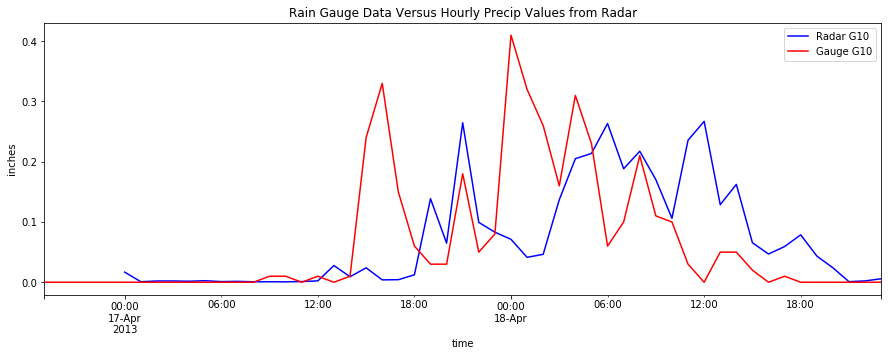

In [232]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(111)

plt.title("Rain Gauge Data Versus Hourly Precip Values from Radar")
plt.ylabel("inches")
df_new.plot(x='time', y="G10", label="Radar" + " G10", color='blue', ax=ax1)
hp_new.plot(x='time', y="G10", label="Gauge" + " G10", color='red', ax=ax1 )

<Figure size 1152x576 with 0 Axes>

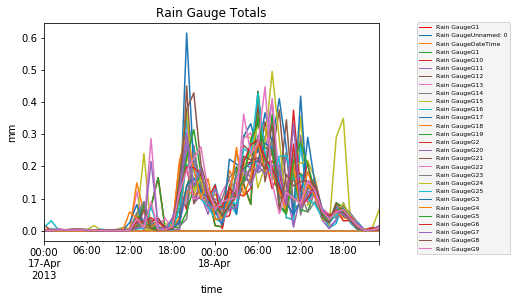

In [230]:
col_names = list(df_mean.columns.values)

fig = plt.figure(figsize=(16, 8))
ax = df_new.plot(x='time', y="G1", label="Rain Gauge" + "G1", color='red')
for i in col_names:
    df_new.plot(x='time', y=i, label="Rain Gauge" + i, ax=ax)
legend = plt.legend(bbox_to_anchor=(1.4, 1.017), prop={'size': 6})
legend.get_frame().set_facecolor('#f2f2f2')
for legobj in legend.legendHandles:
    legobj.set_linewidth(1.0)
plt.ylabel("mm")
plt.title("Rain Gauge Totals")
plt.show()

# fig= plt.figure(figsize=(8,8))
# ax1=